# Example: Using the Standard ESN

This tutorial shows how to use the ESN class, covering:

- building and training the network

- making sample predictions and comparing the predictions to test data

- storing the network weights and re-reading the network to an ESN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lorenz import Lorenz96

In [2]:
plt.style.use("./xesn.mplstyle")

## Create training and testing data

Here we generate a time series using the 6 Dimensional version of the Lorenz 96 model
<cite data-cite="lorenz_predictability_1996">(Lorenz 1996)</cite>.
First we spinup the model dynamics before making the training data, then discard a brief transient period, and finally 
create the test dataset.

This uses a local module here in the documentation directory.

In [3]:
model = Lorenz96(N=6)

In [4]:
rs = np.random.RandomState(0)
data = model.generate(n_steps=500, x0=rs.normal(size=(model.N,)))
trainer = model.generate(n_steps=40_000, x0=data[:, -1])
transient = model.generate(n_steps=1_000, x0=trainer[:,-1])
tester = model.generate(n_steps=1_000, x0=transient[:,-1])

## Create the ESN

Here we create a network that fully emulates the 6D Lorenz96 system, so it has input and output dimension
equal to 6. The other parameters have been obtained from previous experiments, and are used just as an example.

In [5]:
from xesn import ESN

In [6]:
esn = ESN(
    n_input=model.N,
    n_output=model.N,
    n_reservoir=500,
    leak_rate=0.87,
    tikhonov_parameter=6.9e-7,
    input_kwargs={
        "factor": 0.86,
        "normalization": "svd",
        "distribution": "uniform",
        "random_seed": 0,
    },
    adjacency_kwargs={
        "factor":0.71,
        "normalization": "eig",
        "distribution": "uniform",
        "is_sparse": True,
        "connectedness": 5,
        "random_seed": 1,
    },
    bias_kwargs={
        "factor": 1.8,
        "distribution": "uniform",
        "random_seed": 2,
    },
)

And note that we can always get a printed view of the values set in the ESN

In [7]:
esn

ESN
    n_input:                6
    n_output:               6
    n_reservoir:            500
--- 
    leak_rate:              0.87
    tikhonov_parameter:     6.9e-07
--- 
    Input Matrix:
        factor              0.86
        normalization       svd
        distribution        uniform
        random_seed         0
--- 
    Adjacency Matrix:
        factor              0.71
        normalization       eig
        distribution        uniform
        is_sparse           True
        connectedness       5
        random_seed         1
--- 
    Bias Vector:
        factor              1.8
        distribution        uniform
        random_seed         2

<div class="alert alert-info">

**Note:**
It is usually a good idea to use the ``random_seed`` to control the randomly generated matrices, so that results are consistent.
Once reasonable performance is obtained, the seed can be varied to determine how dependent the results are on the
exact matrices and vector chosen.

</div>

## Build the network and train the readout matrix

The [.build()](api.rst#xesn.ESN.build)
method creates the two random matrices and the random bias vector.
Once these are generated, we can run [.train()](api.rst#xesn.ESN.train) to learn the readout matrix weights.

In [8]:
esn.build()

In [9]:
%%time
esn.train(trainer, batch_size=5_000)

CPU times: user 9.62 s, sys: 95.4 ms, total: 9.71 s
Wall time: 1.69 s


<div class="alert alert-info">

**Note**: the ``batch_size`` parameter should be chosen so that ``batch_size x n_reservoir`` can fit comfortably in
memory. Here we choose a somewhat conservative value.

</div>

## Test the network

Here we use [.test()](api.rst#xesn.ESN.test) to make a sample prediction, and package that prediction together with the original test data.
In order to only make a sample prediction, and not return the test data as well, see
[.predict()](api.rst#xesn.ESN.predict).

In [10]:
xds = esn.test(tester, n_steps=500, n_spinup=500)
xds

<xarray.Dataset>
Dimensions:     (x: 6, ftime: 501)
Coordinates:
  * x           (x) int64 0 1 2 3 4 5
  * ftime       (ftime) float64 0.0 0.01 0.02 0.03 0.04 ... 4.97 4.98 4.99 5.0
    time        (ftime) float64 5.0 5.01 5.02 5.03 5.04 ... 9.97 9.98 9.99 10.0
Data variables:
    prediction  (x, ftime) float64 8.92 8.825 8.704 8.563 ... 2.594 2.761 2.911
    truth       (x, ftime) float64 8.92 8.827 8.71 8.572 ... 1.828 2.305 2.709
Attributes:
    n_input:             6
    n_output:            6
    n_reservoir:         500
    leak_rate:           0.87
    tikhonov_parameter:  6.9e-07
    input_kwargs:        {'factor': 0.86, 'normalization': 'svd', 'distributi...
    adjacency_kwargs:    {'factor': 0.71, 'normalization': 'eig', 'distributi...
    bias_kwargs:         {'factor': 1.8, 'distribution': 'uniform', 'random_s...
    esn_type:            ESN
    description:         Contains a test prediction and matching truth trajec...

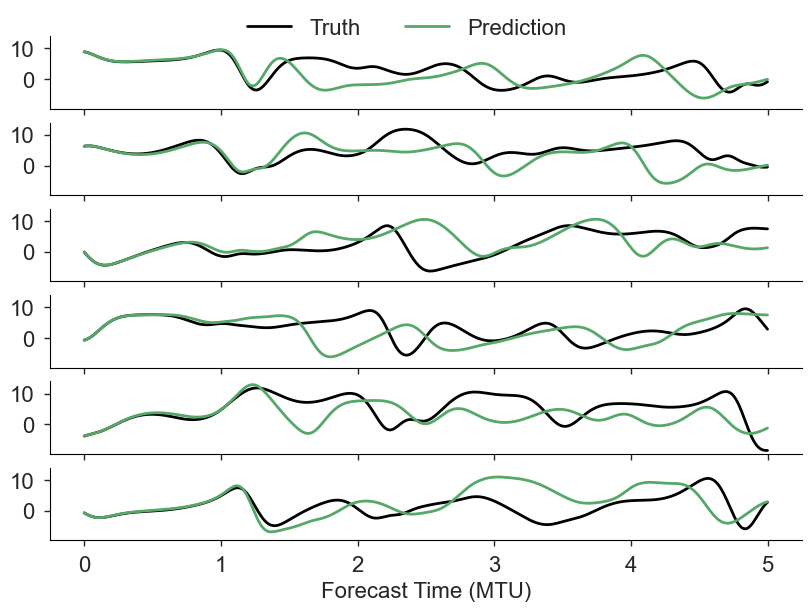

In [11]:
nrows = len(xds.x)
fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)

for i, ax in enumerate(axs):
    xds["truth"].isel(x=i).plot(ax=ax, color="k", label="Truth")
    xds["prediction"].isel(x=i).plot(ax=ax, label="Prediction")
    ax.set(ylabel="", xlabel="", title="")
ax.set(xlabel="Forecast Time (MTU)")
axs[0].legend(loc=(.25,.85),ncol=2)#, bbox_to_anchor=("lower left"))

## Store the Trained Readout Weights

First, we store the weights for future testing by creating an
[xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) from the ESN with
[.to_xds()](api.rst#xesn.ESN.to_xds).


In [12]:
eds = esn.to_xds()
eds

<xarray.Dataset>
Dimensions:  (ir: 500, iy: 6)
Coordinates:
  * ir       (ir) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * iy       (iy) int64 0 1 2 3 4 5
Data variables:
    Wout     (iy, ir) float64 5.711 -1.021 -0.2417 -1.065 ... 1.022 1.154 5.023
Attributes:
    n_input:             6
    n_output:            6
    n_reservoir:         500
    leak_rate:           0.87
    tikhonov_parameter:  6.9e-07
    input_kwargs:        {'factor': 0.86, 'normalization': 'svd', 'distributi...
    adjacency_kwargs:    {'factor': 0.71, 'normalization': 'eig', 'distributi...
    bias_kwargs:         {'factor': 1.8, 'distribution': 'uniform', 'random_s...

<div class="alert alert-info">

**Note**: the adjacency matrix, input matrix, and bias vector are not stored, but rather all the options needed to recreate them are.
This means that true reproducibility is only possible by setting the ``random_seed`` options, as noted earlier.

</div>

In [13]:
eds.to_zarr("test.zarr")

### Read in the Network and Show Reproducibility

Here we use the [from_zarr()](api.rst#xesn.from_zarr) function to read a zarr store with the ESN weights.
Note that this creates the ESN and runs the [.build](api.rst#xesn.ESN.build) method to create the network.

In [14]:
from xesn import from_zarr

In [15]:
esn2 = from_zarr("test.zarr")

In [16]:
y2 = esn2.predict(tester, n_steps=500, n_spinup=500)

In [17]:
np.abs(xds["prediction"]-y2).max()

<xarray.DataArray ()>
array(1.24265043e-09)

## Cleanup

In [18]:
from shutil import rmtree

In [19]:
rmtree("test.zarr")